In [2]:
hr_path = '/Applications/ML projects/Super Resolution/high res/'
lr_path = '/Applications/ML projects/Super Resolution/low res/'
csv = '/Applications/ML projects/Super Resolution/image_data.csv'

In [5]:
import pandas as pd

dataset = pd.read_csv(csv)
dataset

,low_res,high_res
0,1_2.jpg,1.jpg
1,2_2.jpg,2.jpg
2,3_2.jpg,3.jpg
3,4_2.jpg,4.jpg
4,5_2.jpg,5.jpg
...,...,...
3757,1250_6.jpg,1250.jpg
3758,1251_6.jpg,1251.jpg
3759,1252_6.jpg,1252.jpg
3760,1253_6.jpg,1253.jpg


In [3]:
from numpy import asarray
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from tqdm import tqdm
from numpy import load
from numpy import savez_compressed

In [11]:
def load_images(hr_path, lr_path, dataset, size=(256, 256)):
    lrFiles = dataset['low_res'].values
    hrFiles = dataset['high_res'].values
    SUBSET = len(hrFiles) // 3

    lr2Files = lrFiles[:SUBSET]
    lr4Files = lrFiles[SUBSET:SUBSET * 2]
    lr6Files = lrFiles[SUBSET * 2:SUBSET * 3]
    hrFiles = hrFiles[:SUBSET]

    lr2img, lr4img, lr6img, hrimg = [], [], [], []

    for i in tqdm(range(SUBSET)):
        lr2img.append(img_to_array(load_img(lr_path + lr2Files[i], target_size=size)))
        lr4img.append(img_to_array(load_img(lr_path + lr4Files[i], target_size=size)))
        lr6img.append(img_to_array(load_img(lr_path + lr6Files[i], target_size=size)))
        hrimg.append(img_to_array(load_img(hr_path + hrFiles[i], target_size=size)))

    return [asarray(lr2img), asarray(lr4img), asarray(lr6img), asarray(hrimg)]


In [13]:
lr2img, lr4img, lr6img, hrimg = load_images(hr_path, lr_path, dataset)
filename = 'imgs_256.npz'
savez_compressed(filename, lr2img, lr4img, lr6img, hrimg)
print('Saved dataset: ', filename)

100%|██████████| 1254/1254 [01:19<00:00, 15.70it/s]


Saved dataset:  imgs_256.npz


In [3]:
data = load('imgs_256.npz')
lr2img, lr4img, lr6img, hrimg = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', lr2img.shape, lr4img.shape, lr6img.shape, hrimg.shape)

Loaded:  (1254, 256, 256, 3) (1254, 256, 256, 3) (1254, 256, 256, 3) (1254, 256, 256, 3)


In [3]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [4]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    mimg = Input(shape=image_shape)
    nmimg = Input(shape=image_shape)

    merged = Concatenate()([mimg, nmimg])

    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([mimg, nmimg], patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [5]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [6]:
def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [7]:
def define_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

In [8]:
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    source = Input(shape=image_shape)
    gen_out = g_model(source)
    dis_out = d_model([source, gen_out])

    model = Model(source, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

In [9]:
def load_real_samples(filename):
    data = load(filename)
    source1, source2, source3, target = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    source1 = (source1 - 127.5) / 127.5
    source2 = (source2 - 127.5) / 127.5
    source3 = (source3 - 127.5) / 127.5
    target = (target - 127.5) / 127.5
    return [source1, source2, source3, target]

In [10]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [11]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [12]:
def train(d_model, g_model, gan_model, dataset, n_epochs=3):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    n_steps = int(len(trainA))
    n_batch = 1

    for i in range(n_epochs):
        for j in range(n_steps):
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (j+1, d_loss1, d_loss2, g_loss))

In [13]:
dataset = load_real_samples('imgs_256.npz')
print('Loaded: ', dataset[0].shape, dataset[1].shape, dataset[2].shape, dataset[3].shape)
image_shape = dataset[0].shape[1:]

Loaded:  (1254, 256, 256, 3) (1254, 256, 256, 3) (1254, 256, 256, 3) (1254, 256, 256, 3)


In [20]:
d64_model = define_discriminator(image_shape)
g64_model = define_generator(image_shape)
gan64_model = define_gan(g64_model, d64_model, image_shape)

In [14]:
d42_model = define_discriminator(image_shape)
g42_model = define_generator(image_shape)
gan42_model= define_gan(g42_model, d42_model, image_shape)

2023-02-09 16:44:16.968520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
d2h_model = define_discriminator(image_shape)
g2h_model = define_generator(image_shape)
gan2h_model = define_gan(g2h_model, d2h_model, image_shape)

In [23]:
train(d64_model, g64_model, gan64_model, [dataset[2], dataset[1]])

1/1 [==============================] - 0s 429ms/step
>1, d1[0.389] d2[0.880] g[74.188]
1/1 [==============================] - 0s 119ms/step
>2, d1[0.369] d2[0.941] g[40.083]
1/1 [==============================] - 0s 119ms/step
>3, d1[0.312] d2[0.719] g[56.315]
1/1 [==============================] - 0s 118ms/step
>4, d1[0.423] d2[0.622] g[41.915]
1/1 [==============================] - 0s 115ms/step
>5, d1[0.493] d2[0.644] g[66.954]
1/1 [==============================] - 0s 116ms/step
>6, d1[0.405] d2[0.631] g[42.526]
1/1 [==============================] - 0s 115ms/step
>7, d1[0.487] d2[0.476] g[41.012]
1/1 [==============================] - 0s 118ms/step
>8, d1[0.493] d2[0.579] g[65.527]
1/1 [==============================] - 0s 117ms/step
>9, d1[0.643] d2[0.934] g[38.721]
1/1 [==============================] - 0s 124ms/step
>10, d1[0.626] d2[0.450] g[39.351]
1/1 [==============================] - 0s 138ms/step
>11, d1[0.404] d2[0.473] g[33.316]
1/1 [==============================] - 0s

In [24]:
g64_model.save('g64_model.h5')

In [16]:
train(d42_model, g42_model, gan42_model, [dataset[1], dataset[0]])

1/1 [==============================] - 1s 662ms/step
>1, d1[0.358] d2[0.878] g[78.003]
1/1 [==============================] - 0s 150ms/step
>2, d1[0.321] d2[0.777] g[63.425]
1/1 [==============================] - 0s 142ms/step
>3, d1[0.404] d2[0.614] g[38.029]
1/1 [==============================] - 0s 167ms/step
>4, d1[0.366] d2[0.608] g[53.450]
1/1 [==============================] - 0s 145ms/step
>5, d1[0.372] d2[0.416] g[58.725]
1/1 [==============================] - 0s 156ms/step
>6, d1[0.619] d2[0.597] g[60.875]
1/1 [==============================] - 0s 149ms/step
>7, d1[0.440] d2[0.543] g[42.670]
1/1 [==============================] - 0s 160ms/step
>8, d1[0.447] d2[0.659] g[48.455]
1/1 [==============================] - 0s 154ms/step
>9, d1[0.492] d2[0.507] g[31.049]
1/1 [==============================] - 0s 141ms/step
>10, d1[0.628] d2[0.622] g[51.793]
1/1 [==============================] - 0s 166ms/step
>11, d1[0.599] d2[0.673] g[58.482]
1/1 [==============================] - 0s

In [17]:
g42_model.save('g42_model.h5')

In [18]:
train(d2h_model, g2h_model, gan2h_model, [dataset[0], dataset[3]])

1/1 [==============================] - 1s 581ms/step
>1, d1[0.613] d2[0.823] g[64.148]
1/1 [==============================] - 0s 110ms/step
>2, d1[0.315] d2[0.603] g[82.851]
1/1 [==============================] - 0s 110ms/step
>3, d1[0.405] d2[0.575] g[50.394]
1/1 [==============================] - 0s 108ms/step
>4, d1[0.385] d2[0.577] g[44.487]
1/1 [==============================] - 0s 108ms/step
>5, d1[0.381] d2[0.526] g[50.821]
1/1 [==============================] - 0s 110ms/step
>6, d1[0.442] d2[0.547] g[27.016]
1/1 [==============================] - 0s 110ms/step
>7, d1[0.497] d2[0.767] g[55.780]
1/1 [==============================] - 0s 111ms/step
>8, d1[0.517] d2[0.495] g[34.390]
1/1 [==============================] - 0s 109ms/step
>9, d1[0.552] d2[0.470] g[21.807]
1/1 [==============================] - 0s 111ms/step
>10, d1[0.513] d2[0.448] g[48.803]
1/1 [==============================] - 0s 111ms/step
>11, d1[0.586] d2[0.666] g[49.588]
1/1 [==============================] - 0s

In [19]:
g2h_model.save('g2h_model.h5')

In [7]:
from numpy import expand_dims
from keras.models import load_model
from matplotlib import pyplot

In [4]:
def load_image(filename, size=(256, 256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = (pixels - 127.5) / 127.5
    pixels = expand_dims(pixels, 0)
    return pixels

In [6]:
source = load_image(lr_path + '1_6.jpg')
target = load_image(hr_path + '1.jpg')
g64_model = load_model('g64_model.h5')
g42_model = load_model('g42_model.h5')
g2h_model = load_model('g2h_model.h5')

2023-02-09 21:59:31.150784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


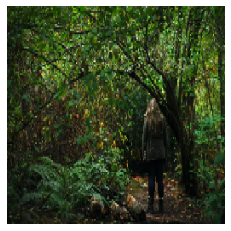

In [13]:
source = (source + 1) / 2.0
pyplot.imshow(source[0])
pyplot.axis('off')
pyplot.show()

1/1 [==============================] - 0s 426ms/step


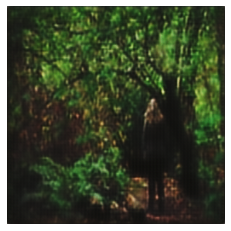

In [8]:
gen_image = g2h_model.predict(g42_model.predict(g64_model.predict(source)))
gen_image = (gen_image + 1) / 2.0
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

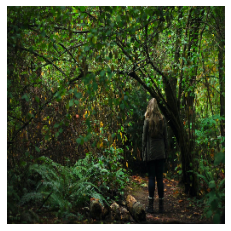

In [12]:
target = (target + 1) / 2.0
pyplot.imshow(target[0])
pyplot.axis('off')
pyplot.show()